# Progetto OneyData: Shopping Missions

#### Francesco Bellogi

### Abstract

<p style='text-align: justify;'> L’obbiettivo del progetto consiste nell’individuare le shopping mission dei clienti di un supermercato, ovvero l’intento con cui vi si sono recati, che regola il comportamento di questi ultimi mentre si aggirano tra corsie e scaffali, magari anche modificandosi nel corso della permanenza all’interno del supermercato.
Ho a disposizione un dataset contenente circa 600.000 transazioni. Ad ogni transazione è associato il prodotto acquistato, una serie di variabili relative alla classe merceologica a cui il prodotto appartiene, la quantità acquistata, il prezzo pagato per la relativa quantità e un id scontrino.
Il risultato del progetto consiste quindi nell’assegnazione di una shopping mission ad ognuno dei circa 77.000 id scontrino.
L’approccio al problema che ho seguito è stato in prima battuta di segmentare gli scontrini, o clienti, in 3 macro cluster per poi andare a indagare ognuno di questi cluster più in profondità.
La scelta dei tre macro cluster iniziali si è basata sull’assunzione che i tipi di spesa, o intenzioni di spesa al supermercato, si possano fondamentalmente dividere in tre grandi gruppi. Una piccola spesa mirata, volta soddisfare un desiderio o una necessità di quel momento, dove il cliente si reca al supermercato per comprare poche unità di poche categorie diverse. Una spesa più varia e più corposa che può essere ad esempio la spesa di beni di consumo per la settimana, magari per una famiglia. Infine, una grande spesa di approvvigionamento fatta anche di scorte di prodotti più durevoli.
Il dataset è stato depurato di prodotti inutili ai fini dell’analisi come le buste di plastica che si acquistano in cassa per pochi centesimi o i prodotti premio acquistati con punti fedeltà. Dopo qualche analisi descrittiva-esplorativa le classi merceologiche sono state riviste e raggruppate per ridurre la dimensionalità del dataset una volta applicato un one-hot encoding al fine di trasformare la variabile categorica prodotto in una serie di variabili numeriche raggruppando per id scontrino.
I 3 cluster di partenza sono stati individuati con un k-means che ha preso in input solamente il numero di unità acquistate e il numero di categorie prodotto distinte presenti nello scontrino. 
L'assegnazione delle shopping mission nel caso dei due cluster contenenti le spese settimanli e le grandi spese è coincisa con il cluster stesso. Nel caso del cluster popolato dalle piccole spese di necessità è stata individuata la shopping mission nella necessità prevalente, in termini di turnover, all'interno dello scontrino. </p>

### Parte 1: Analisi Descrittiva e Data Wrangling

Importo package necessari

In [63]:
import pandas as pd
import pandasql as ps
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline 

In [64]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',-1)

Importo i dati.   
Il dataset contiene 617.798 righe (acquisti) e 9 colonne.

In [65]:
import pandas as pd
df=pd.read_excel('dati_iulm_2020.xlsx')
print(df.shape)
df.head()

(617798, 9)


,ID_SCONTRINO,PRODUCT_EAN,PRODUCT_NAME,CATEGORY_ID,CATEGORY_NAME,SUB_CATEGORY_ID,SUB_CATEGORY_NAME,TURNOVER,UNITS
0,1749196095,8005476707417,6 PINGUINO MARCA PRIVATA,917,GELATI/PASTICCERIA,9305,STECCHI CLASSICI,3.2319,1
1,1749195359,8002580257937,"YOGURT 0,1% FRAGOLAX2 PARMALAT",878,YOGURT,9080,YOGURT MAGRO PEZZI,1.6929,1
2,1749196095,8005476265849,6 CONISSIMI PANNA MARCA PRIVATA,917,GELATI/PASTICCERIA,9316,CONI,3.9159,1
3,1749195359,5000112565348,COCA COLA REGUL FLASH ML 1500,722,BIBITE ANALCOLICHE GASSATE,8058,COLE,2.6505,1
4,1749195619,8002004217554,GRANBIRAGHI GRATTUG. 100GR,872,FORMAGGI DURI L.S.,9126,FORMAGGIO GRATTUGIATO,2.5479,1


In [66]:
df.dtypes

ID_SCONTRINO         int64  
PRODUCT_EAN          int64  
PRODUCT_NAME         object 
CATEGORY_ID          int64  
CATEGORY_NAME        object 
SUB_CATEGORY_ID      int64  
SUB_CATEGORY_NAME    object 
TURNOVER             float64
UNITS                int64  
dtype: object

In [67]:
print('Ci sono {} categorie distinte.'.format(len(df['CATEGORY_NAME'].unique())))

Ci sono 414 categorie distinte.


In [68]:
print('Ci sono {} sotto-categorie distinte.'.format(len(df['SUB_CATEGORY_NAME'].unique())))

Ci sono 2449 sotto-categorie distinte.


In [69]:
print('Ci sono {} prodotti distinti.'.format(len(df['PRODUCT_NAME'].unique())))

Ci sono 32023 prodotti distinti.


In [8]:
df_count = df[['CATEGORY_NAME', 'UNITS']].groupby('CATEGORY_NAME').sum().reset_index()
df_count=df_count.sort_values(by=['UNITS'], ascending=False)
df_count.head(100)

,CATEGORY_NAME,UNITS
16,ACQUE MINERALI,106746
344,SACCHETTI,44164
224,LATTE A LUNGA CONSERVAZIONE,22479
329,PRODOTTI PER ANIMALI,17779
183,GELATI/PASTICCERIA,17712
412,YOGURT,17377
52,BIRRE,17372
50,BIBITE ANALCOLICHE GASSATE,16909
253,MERENDINE,14441
292,PASTA DI SEMOLA,12823


In [9]:
df_count_sub = df[['SUB_CATEGORY_NAME', 'UNITS']].groupby('SUB_CATEGORY_NAME').sum().reset_index()
df_count_sub=df_count_sub.sort_values(by=['UNITS'], ascending=False)
df_count_sub.head(100)

,SUB_CATEGORY_NAME,UNITS
1404,NATURALE BOTTIGLIA PLASTICA,71804
2004,SHOPPERS PLASTICA,43379
902,EFFERV NAT. BOTTIGLIA.PLASTICA,19896
1217,LATTE UHT PS,13494
90,ACQUA NATURALE FINO A 1 LT,7359
683,COLE,6478
1551,PASTA SEMOLA CORTA,6372
1179,LAGER NORM PREM BOTTIG FINO 49,5784
1055,GELATI VASCHETTE,5778
1385,MOZZARELLE VACCINE,5244


Elimino sacchetti,buste di plastica e premi fedeltà dal dataset:

In [10]:
df=df[df.CATEGORY_NAME !="SACCHETTI"]
df=df[df.CATEGORY_NAME !="OPERAZIONE FEDELTA' FINE ANNO"]
print(df.shape)

(585811, 9)


Prima di proseguire, riclassifico la variabile CATEGORY_NAME aggregando ulteriormente per ridurre il numero di variabili:

In [11]:
df['CATEGORY_NEW']=df['CATEGORY_NAME']

In [12]:
df.loc[df['CATEGORY_NAME'].str.contains('PASTA'), 'CATEGORY_NEW'] = 'PASTA'

In [13]:
df.loc[df['CATEGORY_NAME'].str.contains('BIBITE'), 'CATEGORY_NEW'] = 'BIBITE'

In [14]:
df.loc[df['CATEGORY_NAME'].str.contains('ANIMAL'), 'CATEGORY_NEW'] = 'PRODOTTI PER ANIMALI'

In [15]:
df.loc[df['CATEGORY_NAME'].str.contains('PASTICCERIA'), 'CATEGORY_NEW'] = 'GELATI/PASTICCERIA/DESSERT'
df.loc[df['CATEGORY_NAME'].str.contains('DESSERT'), 'CATEGORY_NEW'] = 'GELATI/PASTICCERIA/DESSERT'

In [16]:
df.loc[df['CATEGORY_NAME'].str.contains('IGIEN'), 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME']=='DEODORANTI PERSONA', 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME'].str.contains('CAPELLI'), 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME']=='CURA PERSONA', 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME']=='CURA SALUTE', 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME']=='COSMESI', 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME'].str.contains('BARBA'), 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME']=='MONDO NATURALE', 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NAME']=='MINITAGLIE', 'CATEGORY_NEW'] = 'IGIENE/CURA PERSONALE'

In [17]:
df.loc[df['CATEGORY_NAME']=='BIRRE', 'CATEGORY_NEW'] = 'BIRRE/VINI'
df.loc[df['CATEGORY_NAME']=='VINI', 'CATEGORY_NEW'] = 'BIRRE/VINI'

In [18]:
df.loc[df['CATEGORY_NAME']=='IV-V GAMMA', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='ALTRA FRUTTA ESTIVA', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='FRUTTA AUTUNNALE', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='FRUTTA BIO', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='VERDURE FOGLIA COMPATTE', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='VERDURE IN FOGLIA', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='VERDURA BIO', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='RADICI/TUBERI/BULBI', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='AGRUMI', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='MELE/PERE', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'
df.loc[df['CATEGORY_NAME']=='ESOTICA/SOTTOBOSCO', 'CATEGORY_NEW'] = 'VERDURE E FRUTTA'

In [19]:
df.loc[df['CATEGORY_NAME'].str.contains('FORMAGG'), 'CATEGORY_NEW'] = 'FORMAGGI'
df.loc[df['CATEGORY_NAME']=='FUSI E FILATINI', 'CATEGORY_NEW'] = 'FORMAGGI'
df.loc[df['CATEGORY_NAME']=="SPECIALITA' ESTERE L.S.", 'CATEGORY_NEW'] = 'FORMAGGI'

In [20]:
df.loc[df['CATEGORY_NAME'].str.contains('PESCI'), 'CATEGORY_NEW'] = 'PESCE'
df.loc[df['CATEGORY_NAME'].str.contains('ITTICI'), 'CATEGORY_NEW'] = 'PESCE'

In [21]:
df.loc[df['CATEGORY_NAME'].str.contains('PULIZIA'), 'CATEGORY_NEW'] = 'PRODOTTI PULIZIA'
df.loc[df['CATEGORY_NAME']=='CURA TESSUTI', 'CATEGORY_NEW'] = 'PRODOTTI PULIZIA'
df.loc[df['CATEGORY_NAME']=='PRODOTTI PER LA CASA', 'CATEGORY_NEW'] = 'PRODOTTI PULIZIA'
df.loc[df['CATEGORY_NAME'].str.contains('DETERSIV'), 'CATEGORY_NEW'] = 'PRODOTTI PULIZIA'
df.loc[df['CATEGORY_NAME']=='ASCIUGATUTTO', 'CATEGORY_NEW'] = 'PRODOTTI PULIZIA'

In [22]:
df.loc[df['CATEGORY_NAME']=='BIANCHERIA TAVOLO', 'CATEGORY_NEW'] = 'BIANCHERIA'
df.loc[df['CATEGORY_NAME']=='BIANCHERIA BAGNO', 'CATEGORY_NEW'] = 'BIANCHERIA'
df.loc[df['CATEGORY_NAME']=='BIANCHERIA TRAPUNTE PLAIDS', 'CATEGORY_NEW'] = 'BIANCHERIA'
df.loc[df['CATEGORY_NAME']=='BIANCHERIA CUCINA', 'CATEGORY_NEW'] = 'BIANCHERIA'
df.loc[df['CATEGORY_NAME']=='BIANCHERIA LETTO', 'CATEGORY_NEW'] = 'BIANCHERIA'

In [23]:
df.loc[df['CATEGORY_NAME'].str.contains('OLIO'), 'CATEGORY_NEW'] = 'OLIO/ACETO'
df.loc[df['CATEGORY_NAME'].str.contains('ACETO'), 'CATEGORY_NEW'] = 'OLIO/ACETO'

In [24]:
df.loc[df['CATEGORY_NAME'].str.contains('CALZATURE'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('INTIMO'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('PANTALONI'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('CALZE'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('MARE'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('GIUBBOTTI/GIACCONI'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('JEANS'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('PANTOFOLE'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('MAGLIERIA'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('CITTA'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('NOTTE'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('JERSERIA'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('COORDINABILI'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('SLIP'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('COLLANT'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('GONNE'), 'CATEGORY_NEW'] = 'VESTIARIO'
df.loc[df['CATEGORY_NAME'].str.contains('CAMICE'), 'CATEGORY_NEW'] = 'VESTIARIO'

In [25]:
df.loc[df['CATEGORY_NAME'].str.contains('BIMBI'), 'CATEGORY_NEW'] = 'PRODOTTI BAMBINI'
df.loc[df['CATEGORY_NAME'].str.contains('INFANZIA'), 'CATEGORY_NEW'] = 'PRODOTTI BAMBINI'
df.loc[df['CATEGORY_NAME'].str.contains('GIOCATTOL'), 'CATEGORY_NEW'] = 'PRODOTTI BAMBINI'
df.loc[df['CATEGORY_NAME'].str.contains('NEONAT'), 'CATEGORY_NEW'] = 'PRODOTTI BAMBINI'
df.loc[df['CATEGORY_NAME'].str.contains('BAMBIN'), 'CATEGORY_NEW'] = 'PRODOTTI BAMBINI'
df.loc[df['CATEGORY_NAME']=='PICCOLA PUERICULTURA', 'CATEGORY_NEW'] = 'PRODOTTI BAMBINI'

In [26]:
df.loc[df['CATEGORY_NAME'].str.contains('SPORT'), 'CATEGORY_NEW'] = 'SPORT'

In [27]:
df.loc[df['CATEGORY_NAME'].str.contains('PRONTI'), 'CATEGORY_NEW'] = 'GASTRONOMIA/PIATTI PRONTI'
df.loc[df['CATEGORY_NAME'].str.contains('GASTRONOMIA'), 'CATEGORY_NEW'] = 'GASTRONOMIA/PIATTI PRONTI'
df.loc[df['CATEGORY_NAME'].str.contains('PRIMI PIATTI'), 'CATEGORY_NEW'] = 'GASTRONOMIA/PIATTI PRONTI'
df.loc[df['CATEGORY_NAME'].str.contains('SECONDI PIATTI'), 'CATEGORY_NEW'] = 'GASTRONOMIA/PIATTI PRONTI'

In [28]:
df.loc[df['CATEGORY_NAME'].str.contains('CONSERVE'), 'CATEGORY_NEW'] = 'CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA'

In [29]:
df.loc[df['SUB_CATEGORY_NAME']=='CONFETTURE E MARMELLATE', 'CATEGORY_NEW'] = 'CONFETTURE/MIELE'
df.loc[df['SUB_CATEGORY_NAME']=='BIO SPALMABILI', 'CATEGORY_NEW'] = 'CONFETTURE/MIELE'
df.loc[df['SUB_CATEGORY_NAME'].str.contains('MIELE'), 'CATEGORY_NEW'] = 'CONFETTURE/MIELE'

In [30]:
df.loc[df['CATEGORY_NAME']=='SGL PGC ALIMENTARE', 'CATEGORY_NEW'] = 'ALIMENTI SENZA GLUTINE'

In [31]:
df.loc[df['CATEGORY_NAME'].str.contains('PANE'), 'CATEGORY_NEW'] = 'PANE'
df.loc[df['CATEGORY_NAME'].str.contains('DORATO'), 'CATEGORY_NEW'] = 'PANE'

In [32]:
df.loc[df['CATEGORY_NAME'].str.contains('SALUMI'), 'CATEGORY_NEW'] = 'SALUMI/AFFETTATI'
df.loc[df['CATEGORY_NAME'].str.contains('AFFETTATI'), 'CATEGORY_NEW'] = 'SALUMI/AFFETTATI'
df.loc[df['SUB_CATEGORY_NAME']=='SALAMI', 'CATEGORY_NEW'] = 'SALUMI/AFFETTATI'

In [33]:
df.loc[df['CATEGORY_NAME'].str.contains('CONCIMI'), 'CATEGORY_NEW'] = 'GIARDINO/ORTO'
df.loc[df['CATEGORY_NAME'].str.contains('GIARDINO'), 'CATEGORY_NEW'] = 'GIARDINO/ORTO'
df.loc[df['CATEGORY_NAME'].str.contains('SEMENZE'), 'CATEGORY_NEW'] = 'GIARDINO/ORTO'
df.loc[df['CATEGORY_NAME']=='PIANTE', 'CATEGORY_NEW'] = 'GIARDINO/ORTO'
df.loc[df['CATEGORY_NAME']=='INNAFFIATURA / IRRIGAZIONE', 'CATEGORY_NEW'] = 'GIARDINO/ORTO'

In [34]:
df.loc[df['CATEGORY_NAME'].str.contains('POLL'), 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['CATEGORY_NAME'].str.contains('TACCHINI'), 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['CATEGORY_NAME']=='ELABORATI NOSTRA PRODUZIONE', 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['SUB_CATEGORY_NAME']=='SALSICCE', 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['CATEGORY_NAME'].str.contains('HAMBURGER'), 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['CATEGORY_NAME'].str.contains('ATM'), 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['SUB_CATEGORY_NAME']=='MACINATI CONFEZIONATI', 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['CATEGORY_NAME']=='MACINATI CONFEZIONATI', 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'
df.loc[df['CATEGORY_NAME'].str.contains('CARNI BIANCHE'), 'CATEGORY_NEW'] = 'CARNI BIANCHE/ROSSE'

In [35]:
df.loc[df['CATEGORY_NAME'].str.contains('AUTO'), 'CATEGORY_NEW'] = 'ARTICOLI AUTOMOBILE/MOTO'
df.loc[df['CATEGORY_NAME'].str.contains('MOTO'), 'CATEGORY_NEW'] = 'ARTICOLI AUTOMOBILE/MOTO'
df.loc[df['CATEGORY_NAME'].str.contains('SEDILI'), 'CATEGORY_NEW'] = 'ARTICOLI AUTOMOBILE/MOTO'
df.loc[df['CATEGORY_NAME'].str.contains('PEZZI'), 'CATEGORY_NEW'] = 'ARTICOLI AUTOMOBILE/MOTO'

In [36]:
df.loc[df['CATEGORY_NAME'].str.contains('ARREDO'), 'CATEGORY_NEW'] = 'ARREDO'
df.loc[df['CATEGORY_NAME'].str.contains('DECORAZ'), 'CATEGORY_NEW'] = 'ARREDO'
df.loc[df['CATEGORY_NAME']=='TAVOLI SEDIE E CUSCINI', 'CATEGORY_NEW'] = 'ARREDO'

In [37]:
df.loc[df['PRODUCT_NAME'].isna(), 'PRODUCT_NAME'] = df['SUB_CATEGORY_NAME']

In [42]:
count_nan = df['PRODUCT_NAME'].isna().sum()
print ('Count of NaN: ' + str(count_nan))

Count of NaN: 0


In [47]:
df_count_new = df[['CATEGORY_NEW', 'UNITS']].groupby('CATEGORY_NEW').count().reset_index()
df_count_new=df_count_new.sort_values(by=['UNITS'], ascending=False)
df_count_new.head(100)

,CATEGORY_NEW,UNITS
107,IGIENE/CURA PERSONALE,46484
169,PRODOTTI PULIZIA,37346
98,GELATI/PASTICCERIA/DESSERT,36917
164,PRODOTTI BAMBINI,29583
221,VERDURE E FRUTTA,24619
29,BIBITE,21236
222,VESTIARIO,20584
90,FORMAGGI,18535
168,PRODOTTI PER ANIMALI,16462
226,YOGURT,15738


Le categorie prodotto che registrano meno di 500 unità acquistate vengono raggruppate nella categoria "ALTRE_VARIE":

In [48]:
query = """SELECT DISTINCT a.*, b.units AS ovr_units FROM df a LEFT JOIN df_count_new b ON a.CATEGORY_NEW=b.CATEGORY_NEW """
df2=ps.sqldf(query, locals())
df2.loc[df2['ovr_units']<=500, 'CATEGORY_NEW'] = 'ALTRE VARIE'

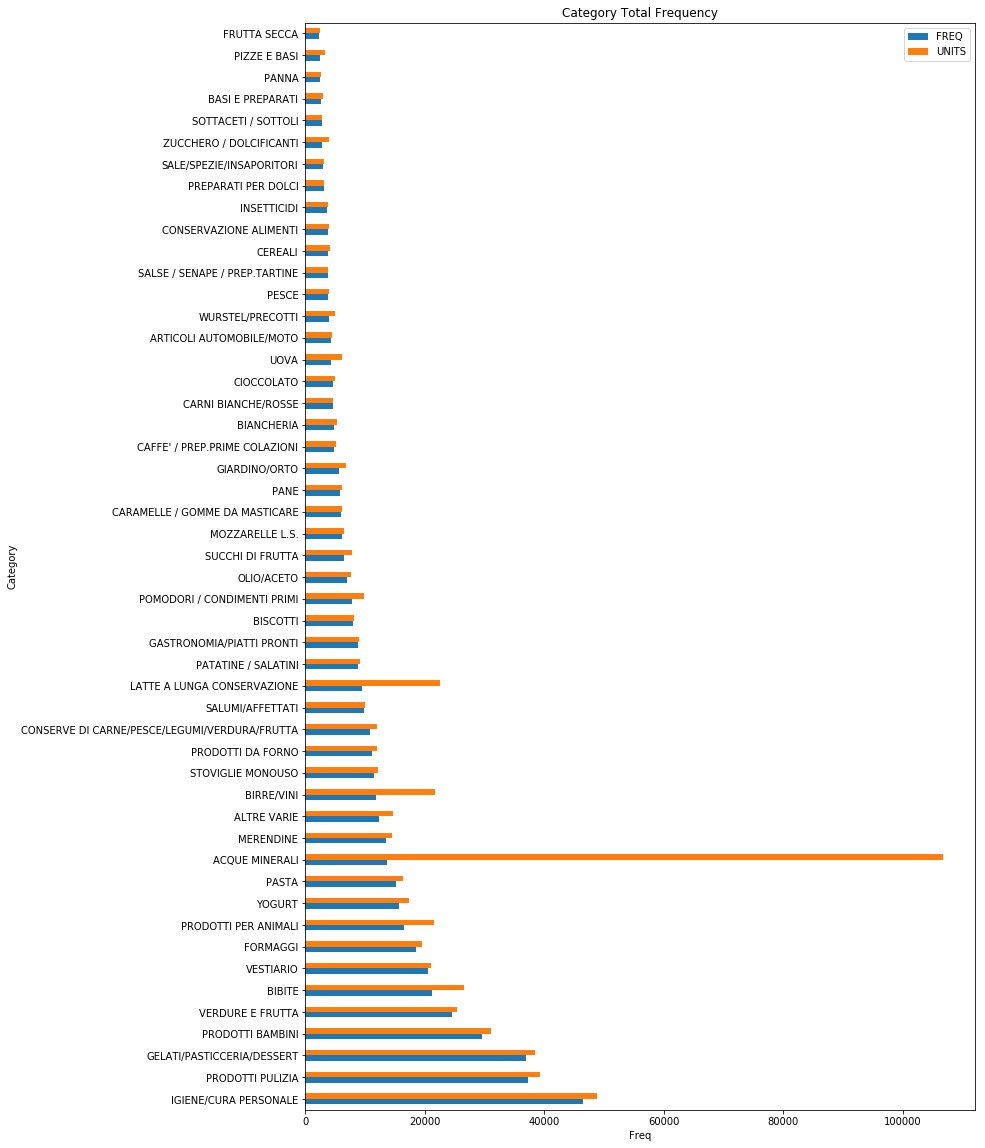

In [49]:
df_count_new_sum = df2[['CATEGORY_NEW', 'UNITS']].groupby('CATEGORY_NEW').sum().reset_index()
df_count_new_cnt = df2[['CATEGORY_NEW', 'UNITS']].groupby('CATEGORY_NEW').count().reset_index()
df_count_new_cnt.rename(columns={'UNITS':'FREQ'}, inplace=True)
df_count_new2 = df_count_new_cnt.join(df_count_new_sum.set_index('CATEGORY_NEW'), on='CATEGORY_NEW')
df_count_new2=df_count_new2.sort_values(by=['FREQ'], ascending=False).head(50).set_index('CATEGORY_NEW')

df_count_new2.plot(kind='barh', figsize=(12, 20))

plt.xlabel('Freq')
plt.ylabel('Category')
plt.title('Category Total Frequency')

plt.show()

Nel grafico sopra, per ogni categoria prodotto è rappresentato in blu il numero di volte in cui compare nel dataset e in arancio il numero totale di unità acquistate. Il numero di unità per costruzione è sempre maggiore o uguale della frequenza, ma è interessante notare come per alcune categorie sia visibilmente molto superiore. Si tratta infatti di categorie di prodotto che vengono spesso vendute in confezioni multiple, come l'acqua e le birre, o aquistati sempre in grandi quantità come il latte a lunga conservazione proprio perchè può essere conservato a lungo.

Esporto il dataset con le nuove categorie:

In [50]:
df2.to_csv('df_new_categories.csv')

Prima di proseguire trasformo il dataset in modo da raggruppare per ID_SCONTRINO, in modo tale che a ogni riga corrisponda un unico scontrino:

In [131]:
# one hot encoding
df3 = pd.get_dummies(df2[['CATEGORY_NEW']], prefix="", prefix_sep="")

df3['ID_SCONTRINO'] = df2['ID_SCONTRINO'] 

ID_SCONTRINO = df3['ID_SCONTRINO']
df3.drop(labels=['ID_SCONTRINO'], axis=1,inplace = True)
df3.insert(0, 'ID_SCONTRINO', ID_SCONTRINO)

df3 = df3.groupby('ID_SCONTRINO').max().reset_index()
df3.drop('ALTRE VARIE', axis=1, inplace= True)

items_import=df2[['ID_SCONTRINO', 'TURNOVER', 'UNITS']].groupby('ID_SCONTRINO').sum().reset_index()

query = """SELECT DISTINCT id_scontrino, COUNT(DISTINCT category_new) AS n_of_categories FROM df GROUP BY id_scontrino """
count_cat=ps.sqldf(query, locals())

items_import = items_import.join(count_cat.set_index('ID_SCONTRINO'), on='ID_SCONTRINO')
df3 = items_import.join(df3.set_index('ID_SCONTRINO'), on='ID_SCONTRINO')
df3.head()

,ID_SCONTRINO,TURNOVER,UNITS,n_of_categories,ACQUE MINERALI,ARTICOLI AUTOMOBILE/MOTO,BASI E PREPARATI,BIANCHERIA,BIBITE,BIRRE/VINI,BISCOTTI,CAFFE' / PREP.PRIME COLAZIONI,CARAMELLE / GOMME DA MASTICARE,CARNI BIANCHE/ROSSE,CEREALI,CIOCCOLATO,CONSERVAZIONE ALIMENTI,CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA,FORMAGGI,FRUTTA SECCA,GASTRONOMIA/PIATTI PRONTI,GELATI/PASTICCERIA/DESSERT,GIARDINO/ORTO,IGIENE/CURA PERSONALE,INSETTICIDI,LATTE A LUNGA CONSERVAZIONE,MERENDINE,MOZZARELLE L.S.,OLIO/ACETO,PANE,PANNA,PASTA,PATATINE / SALATINI,PESCE,PIZZE E BASI,POMODORI / CONDIMENTI PRIMI,PREPARATI PER DOLCI,PRODOTTI BAMBINI,PRODOTTI DA FORNO,PRODOTTI PER ANIMALI,PRODOTTI PULIZIA,SALE/SPEZIE/INSAPORITORI,SALSE / SENAPE / PREP.TARTINE,SALUMI/AFFETTATI,SOTTACETI / SOTTOLI,STOVIGLIE MONOUSO,SUCCHI DI FRUTTA,UOVA,VERDURE E FRUTTA,VESTIARIO,WURSTEL/PRECOTTI,YOGURT,ZUCCHERO / DOLCIFICANTI
0,174920,12.6198,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,174921,0.6669,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,174922,52.5996,15,9,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,174923,30.8826,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,174924,31.2075,7,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [132]:
df3[['TURNOVER', 'UNITS', 'n_of_categories']].describe()

,TURNOVER,UNITS,n_of_categories
count,77300.000000,77300.000000,77300.000000
mean,40.417667,9.702290,4.846468
std,53.786106,12.768629,4.798958
min,0.017100,1.000000,1.000000
25%,10.328400,2.000000,1.000000
50%,23.495400,5.000000,3.000000
75%,49.713975,12.000000,6.000000
max,1848.321900,433.000000,46.000000


Elimino possibili outlier:

In [133]:
df3=df3[df3.TURNOVER<500]
df3=df3[df3.UNITS<250]
df3[['TURNOVER', 'UNITS', 'n_of_categories']].describe()

,TURNOVER,UNITS,n_of_categories
count,77207.000000,77207.000000,77207.000000
mean,39.677902,9.679096,4.846672
std,48.720485,12.525631,4.793955
min,0.017100,1.000000,1.000000
25%,10.294200,2.000000,1.000000
50%,23.444100,5.000000,3.000000
75%,49.555800,12.000000,6.000000
max,498.618900,246.000000,46.000000


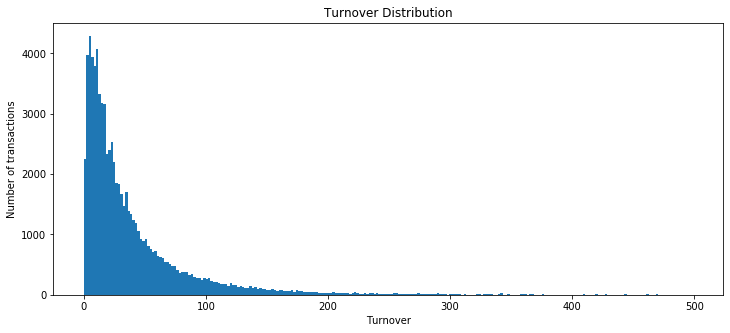

In [134]:
df3['TURNOVER'].plot(kind='hist', figsize=(12, 5), bins=250)
plt.title('Turnover Distribution') # add a title to the histogram
plt.ylabel('Number of transactions') # add y-label
plt.xlabel('Turnover') # add x-label

plt.show()

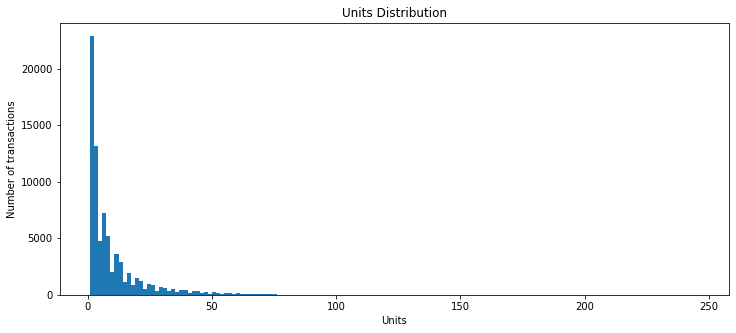

In [135]:
df3['UNITS'].plot(kind='hist', figsize=(12, 5), bins=150)

plt.title('Units Distribution') # add a title to the histogram
plt.ylabel('Number of transactions') # add y-label
plt.xlabel('Units') # add x-label

plt.show()

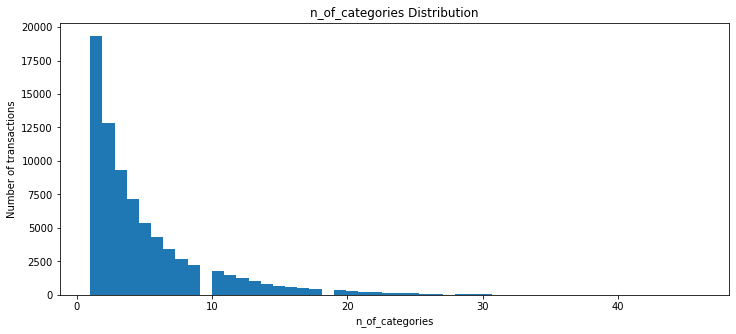

In [136]:
count, bin_edges = np.histogram(df3['n_of_categories'], bins=30)

df3['n_of_categories'].plot(kind='hist', figsize=(12, 5), bins=50)

plt.title('n_of_categories Distribution') # add a title to the histogram
plt.ylabel('Number of transactions') # add y-label
plt.xlabel('n_of_categories') # add x-label

plt.show()

### Parte 2: Clustering

L'assunzione dietro a questo passagio è che una prima grande segmentazione delle shopping mission sia data dalla quantità e varietà di articoli acquistati. In sostanza distinguere le spese di necessità in cui si ha bisogno di qualcosa di preciso in quel momento particolare, dalle grandi spese settimanali o di famiglie dove si fa rifornimento di tutto quello che si pianifica di consumare nel prossimo periodo.

Come primo step cerco quindi dei macro cluster in funzione di quantità di item e numero di categorie distinte.
La scelta di escludere il turnover dal pool di variabili per questo passaggio è stato dato dal fatto che includendolo il clustering segmentava quasi esclusivamente in base ad esso (i tentativi che includono il turnover non sono stati riportati qui). Mentre nella mia assunzione teorica, un consumatore quando va al supermercato ha in mente più meno chiaramente quanto di quante cose vuole acquistare piuttosto che una cifra da spendere.

L'algoritmo che utilizzo è il _k-means_ , il quale però necessità di avere il numero di cluster (k) in input. Per scegliere il k migliore mi affido alla _elbow rule_ :

In [138]:
df_clst = df3[['UNITS', 'n_of_categories']]

In [139]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_clst)
    distortions.append(kmeanModel.inertia_)

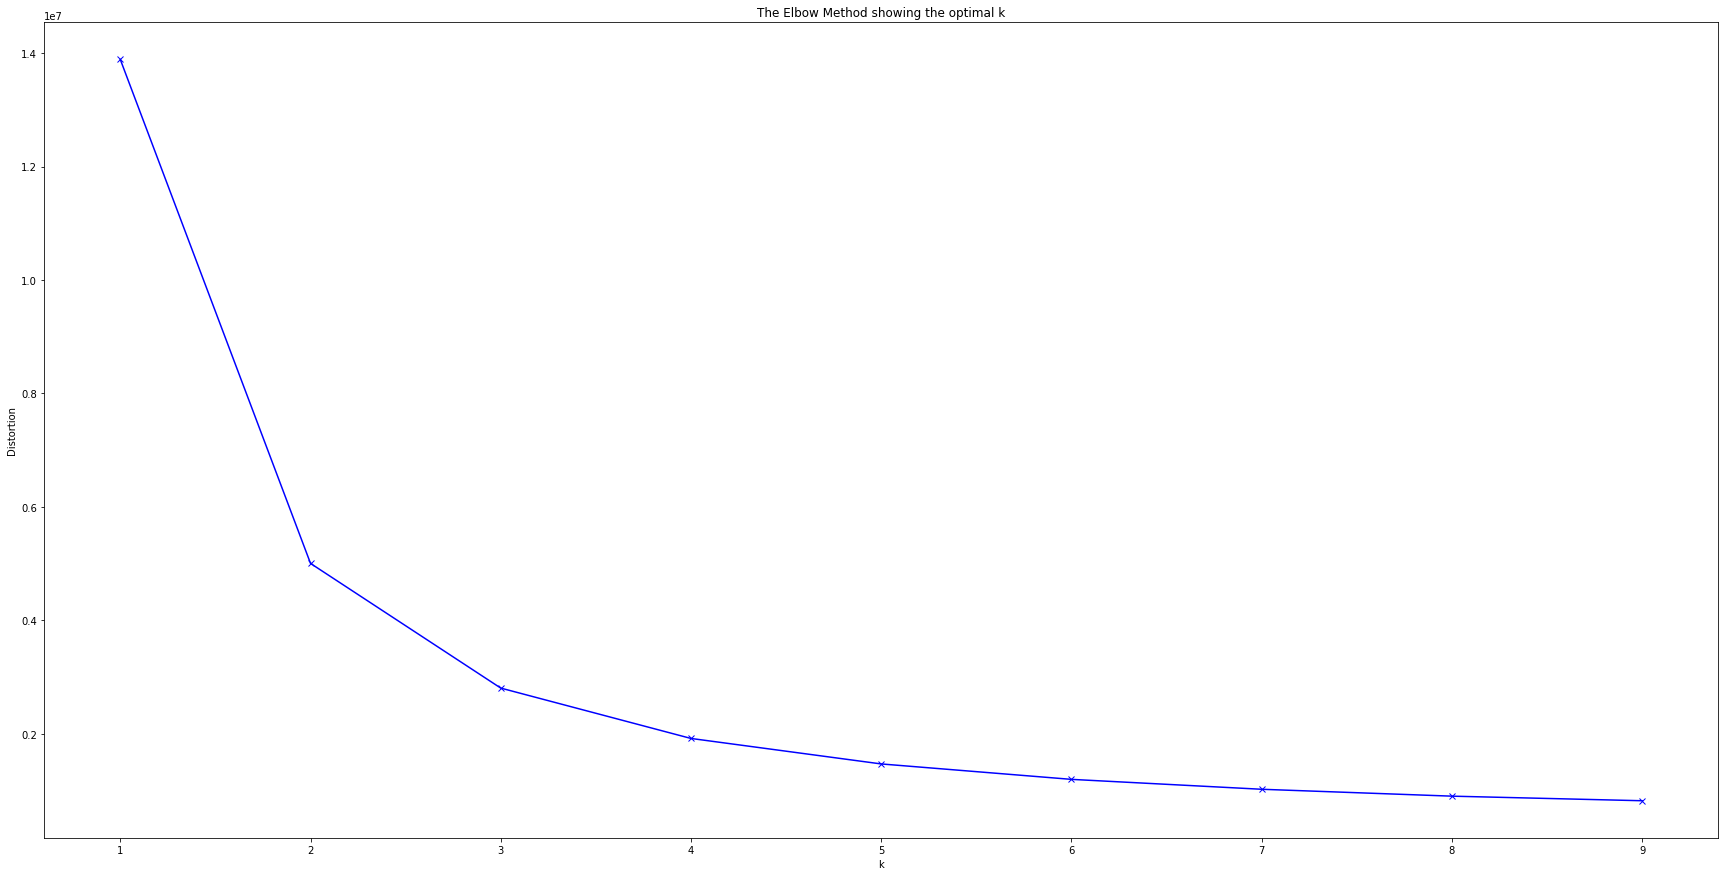

In [140]:
plt.figure(figsize=(30,15))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Dal grafico si nota che un buon "gomito" potrebbe essere in corrispondenza di k=3. 3 cluster può essere anche coerente con l'assunzione teorica fatta sopra sui macro-tipi di spesa.

In [141]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clst)

In [142]:
df_clst.insert(0, 'CLUSTER', kmeans.labels_)
df_clst.groupby('CLUSTER').mean()

,UNITS,n_of_categories
CLUSTER,,
0,4.072015,2.760523
1,49.374825,16.643893
2,19.105108,9.151662


In [143]:
df_clst.groupby('CLUSTER').count()

,UNITS,n_of_categories
CLUSTER,,
0,57016,57016
1,4274,4274
2,15917,15917


Il risultato sono 3 macro cluster:

#### __Cluster 0: Piccola spesa di necessità__
#### __Cluster 1: Grande spesa__
#### __Cluster 2: Spesa settimana/famiglia__

Si noti che il cluster di spese di necessità è di gran lunga il più numeroso (57.016 scontrini) ed è composto da spese con in medi 4 articoli di 2 categorie diverse. Il secondo cluster più numeroso è quello identificabile nella spesa settimanale dove in media vengono aquistate 10 categorie prodotto diverse per un totale in circa 20 articoli. L'ultimo cluster di grandi spese è composto da soli 4.274 scontrini che presentano in media 50 articoli e 17 categorie prodotto differenti.

In [144]:
df3.insert(0, 'CLUSTER', kmeans.labels_)
df3.to_csv('df_macro_clusters.csv', index=False)

In [145]:
df3.head()

,CLUSTER,ID_SCONTRINO,TURNOVER,UNITS,n_of_categories,ACQUE MINERALI,ARTICOLI AUTOMOBILE/MOTO,BASI E PREPARATI,BIANCHERIA,BIBITE,BIRRE/VINI,BISCOTTI,CAFFE' / PREP.PRIME COLAZIONI,CARAMELLE / GOMME DA MASTICARE,CARNI BIANCHE/ROSSE,CEREALI,CIOCCOLATO,CONSERVAZIONE ALIMENTI,CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA,FORMAGGI,FRUTTA SECCA,GASTRONOMIA/PIATTI PRONTI,GELATI/PASTICCERIA/DESSERT,GIARDINO/ORTO,IGIENE/CURA PERSONALE,INSETTICIDI,LATTE A LUNGA CONSERVAZIONE,MERENDINE,MOZZARELLE L.S.,OLIO/ACETO,PANE,PANNA,PASTA,PATATINE / SALATINI,PESCE,PIZZE E BASI,POMODORI / CONDIMENTI PRIMI,PREPARATI PER DOLCI,PRODOTTI BAMBINI,PRODOTTI DA FORNO,PRODOTTI PER ANIMALI,PRODOTTI PULIZIA,SALE/SPEZIE/INSAPORITORI,SALSE / SENAPE / PREP.TARTINE,SALUMI/AFFETTATI,SOTTACETI / SOTTOLI,STOVIGLIE MONOUSO,SUCCHI DI FRUTTA,UOVA,VERDURE E FRUTTA,VESTIARIO,WURSTEL/PRECOTTI,YOGURT,ZUCCHERO / DOLCIFICANTI
0,0,174920,12.6198,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,174921,0.6669,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,174922,52.5996,15,9,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,0,174923,30.8826,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,174924,31.2075,7,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


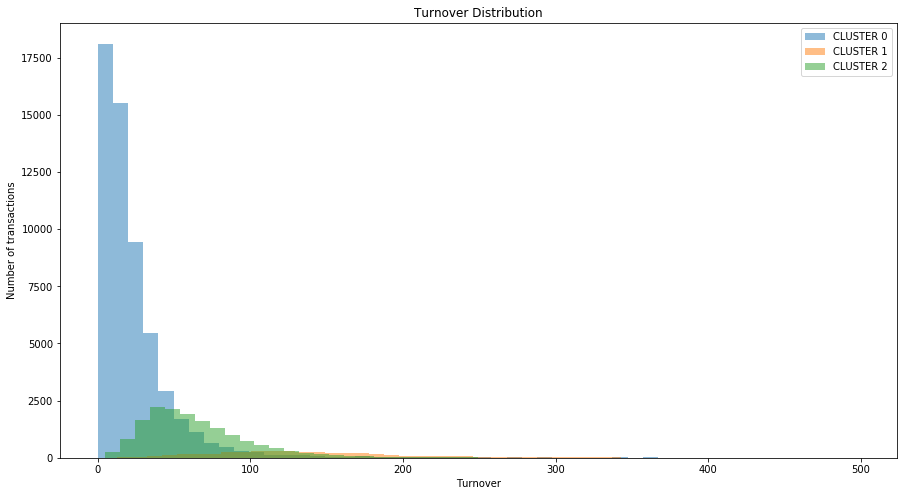

In [146]:
df3['TURNOVER'].loc[df3['CLUSTER']==0].plot(kind='hist', figsize=(15, 8), bins=50, label='CLUSTER 0', alpha=0.5)
df3['TURNOVER'].loc[df3['CLUSTER']==1].plot(kind='hist', figsize=(15, 8), bins=50, label='CLUSTER 1', alpha=0.5)
df3['TURNOVER'].loc[df3['CLUSTER']==2].plot(kind='hist', figsize=(15, 8), bins=50, label='CLUSTER 2', alpha=0.5)

plt.title('Turnover Distribution') # add a title to the histogram
plt.ylabel('Number of transactions') # add y-label
plt.xlabel('Turnover') # add x-label
plt.legend(loc='best')
plt.show()

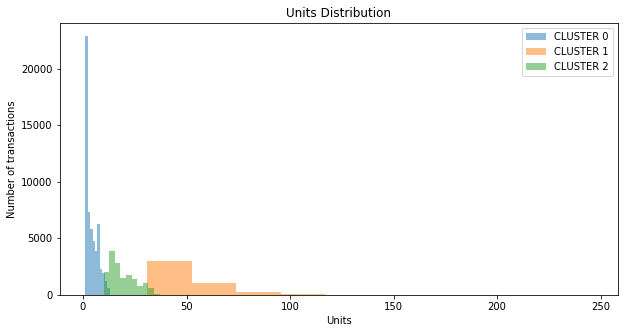

In [147]:
df3['UNITS'].loc[df3['CLUSTER']==0].plot(kind='hist', figsize=(10, 5), label='CLUSTER 0', alpha=0.5)
df3['UNITS'].loc[df3['CLUSTER']==1].plot(kind='hist', figsize=(10, 5), label='CLUSTER 1', alpha=0.5)
df3['UNITS'].loc[df3['CLUSTER']==2].plot(kind='hist', figsize=(10, 5), label='CLUSTER 2', alpha=0.5)


plt.title('Units Distribution') # add a title to the histogram
plt.ylabel('Number of transactions') # add y-label
plt.xlabel('Units') # add x-label
plt.legend(loc='best')
plt.show()

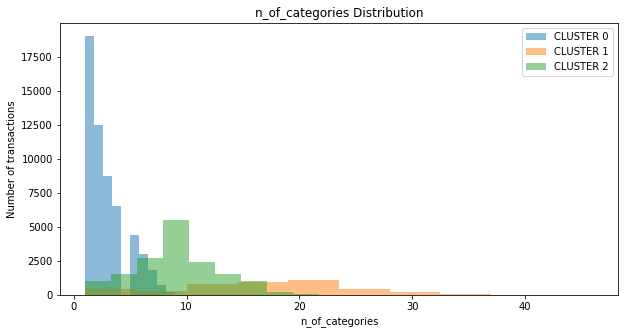

In [148]:

df3['n_of_categories'].loc[df3['CLUSTER']==0].plot(kind='hist', figsize=(10, 5), label='CLUSTER 0', alpha=0.5)
df3['n_of_categories'].loc[df3['CLUSTER']==1].plot(kind='hist', figsize=(10, 5), label='CLUSTER 1', alpha=0.5)
df3['n_of_categories'].loc[df3['CLUSTER']==2].plot(kind='hist', figsize=(10, 5), label='CLUSTER 2', alpha=0.5)

plt.title('n_of_categories Distribution') # add a title to the histogram
plt.ylabel('Number of transactions') # add y-label
plt.xlabel('n_of_categories') # add x-label
plt.legend(loc='best')
plt.show()

In [149]:
df3=pd.read_csv('df_macro_clusters.csv')

### Parte 3: Market Basket Analysis

Per approfondire ulterirmente le dinamiche del dataset, è utile eseguire una semplice market basket analysis sia sul dataset complessivo che sui singoli macro-cluster.

Importo i package necessari:

In [73]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [78]:
df=pd.read_csv('df_new_categories.csv')
clusters = pd.read_csv('df_macro_clusters.csv')

Per questo passaggio scompongo alcune della categorie che avevo aggregato in precedenza:

In [79]:
df['CATEGORY_NEW2']=df['CATEGORY_NEW']
df.loc[df['CATEGORY_NEW']=='GELATI/PASTICCERIA/DESSERT', 'CATEGORY_NEW2'] = df['CATEGORY_NAME']
df.loc[df['CATEGORY_NEW']=='IGIENE/CURA PERSONALE', 'CATEGORY_NEW2'] = df['CATEGORY_NAME']
df.loc[df['CATEGORY_NEW']=='PRODOTTI PULIZIA', 'CATEGORY_NEW2'] = df['CATEGORY_NAME']
df.loc[df['CATEGORY_NEW']=='BIRRE/VINI', 'CATEGORY_NEW2'] = df['CATEGORY_NAME']

Per questa analisi il dataset di partenza deve essere di nuovo trasformato in modo da avere una riga per ogni scontrino e una variabile dummy per ogni categoria prodotto:

In [84]:
# one hot encoding
df1 = pd.get_dummies(df[['CATEGORY_NEW2']], prefix="", prefix_sep="")

df1['ID_SCONTRINO'] = df['ID_SCONTRINO'] 

ID_SCONTRINO = df1['ID_SCONTRINO']
df1.drop(labels=['ID_SCONTRINO'], axis=1,inplace = True)
df1.insert(0, 'ID_SCONTRINO', ID_SCONTRINO)

df1 = df1.groupby('ID_SCONTRINO').max().reset_index()
df1.drop('ALTRE VARIE', axis=1, inplace= True)

items_import=df[['ID_SCONTRINO', 'TURNOVER', 'UNITS']].groupby('ID_SCONTRINO').sum().reset_index()

query = """SELECT DISTINCT id_scontrino, COUNT(DISTINCT category_new) AS n_of_categories FROM df GROUP BY id_scontrino """
count_cat=ps.sqldf(query, locals())

items_import = items_import.join(count_cat.set_index('ID_SCONTRINO'), on='ID_SCONTRINO')
df1 = items_import.join(df1.set_index('ID_SCONTRINO'), on='ID_SCONTRINO')

query = """ SELECT DISTINCT b.CLUSTER, a.* 
            FROM df1 a INNER JOIN clusters b ON a.ID_SCONTRINO=b.ID_SCONTRINO """
df2=ps.sqldf(query, locals())
df2.head()

,CLUSTER,ID_SCONTRINO,TURNOVER,UNITS,n_of_categories,ACQUE MINERALI,ALIMENTI SENZA GLUTINE,APERITIVI/COCKTAIL,ARREDO,ARTICOLI AUTOMOBILE/MOTO,ARTICOLI DA DISEGNO,ARTICOLI DA SCRITTURA,ASCIUGATUTTO,BASI E PREPARATI,BIANCHERIA,BIBITE,BIRRE,BISCOTTI,BURRO/ALTRI GRASSI,CAFFE' / PREP.PRIME COLAZIONI,CARAMELLE / GOMME DA MASTICARE,CARNI BIANCHE/ROSSE,CARTA IGIENICA,CARTOTECNICA,CEREALI,CHINCAGLIERIA,CIOCCOLATO,COLLE/NASTRI/ISOLAMENTO,CONFETTURE/MIELE,CONSERVAZIONE ALIMENTI,CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA,CONTENITORI/BARATTOLI/SISTEMAZ,COSMESI,CREME SPALMABILI,CUBETTI,CURA CAPELLI,CURA PERSONA,CURA SALUTE,CURA TESSUTI,DEODORANTI AMBIENTE,DEODORANTI PERSONA,DESSERT,DETERSIVI LAVASTOVIGLIE,DETERSIVO PER BIANCHERIA,DETERSIVO PIATTI MANO,ETNICO,FARINA / POLENTA,FARMACI SENZA OBBL.DI RICETTA,FAZZOLETTI,FETTE BISCOTTATE,FORMAGGI,FRIGOBOX E BORSE TERMICHE,FRUTTA SECCA,GASTRONOMIA/PIATTI PRONTI,GELATI/PASTICCERIA,GIARDINO/ORTO,GIOCHI DI SOCIETA' E PUZZLE,IGIENE BELLEZZA,IGIENE BOCCA,IGIENE CAPELLI,IGIENE CORPO,IGIENE E CURA KIDS E TEENAGERS,IGIENE PERIODICA,INSETTICIDI,LAMPADINE,LATTE A LUNGA CONSERVAZIONE,LATTE FRESCO,LEGUMI SECCHI,LIQUORI / DISTILLATI,LUBRIFICANTI,MACINATI CONFEZIONATI,MANUTENZIONE E PULIZIA,MATERIALE ELETTRICO,MATERIE PRIME PASTICCERIA,MEDICAZIONE E PREVENZIONE,MERENDINE,MINITAGLIE,MONDO NATURALE,MOZZARELLE L.S.,OLIO/ACETO,PADELLE/CASSERUOLE,PANE,PANIFICATI ARTIGIANALI,PANNA,PASTA,PASTICCERIA,PASTICCERIA CON CREME,PASTICCERIA DA FORNO,PASTICCERIA INDUSTRIALE,PASTICCERIA SURGELATA,PATATINE / SALATINI,PESCE,PILE,PISCINE E ACCESSORI,PIZZE E BASI,POMODORI / CONDIMENTI PRIMI,PREPARATI PER DOLCI,PROD.PER LA BARBA E COSM.UOMO,PRODOTTI BAMBINI,PRODOTTI DA FORNO,PRODOTTI PER ANIMALI,PRODOTTI PER LA CASA,PULIZIA A VAPORE,PULIZIA BAZAR,PULIZIA CHIMICO,RISO,SALE/SPEZIE/INSAPORITORI,SALSE / SENAPE / PREP.TARTINE,SALUMI/AFFETTATI,SALUTISTICO INTEGRATORI,SCIROPPI,SISTEMAZIONE BIANCHERIA,SOLARI,SOTTACETI / SOTTOLI,SPORT,SPUMANTI,STOVIGLIE MONOUSO,SUCCHI DI FRUTTA,THE/INFUSI/PREP. BEVANDE,UFFICIO,UOVA,UTENSILI CUCINA,VERDURE E FRUTTA,VESTIARIO,VINI,WURSTEL/PRECOTTI,YOGURT,ZUCCHERO / DOLCIFICANTI
0,0,174920,12.6198,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,174921,0.6669,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,174922,52.5996,15,9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,174923,30.8826,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,174924,31.2075,7,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Come prima cosa, tramite l'algoritmo Apriori, viene calcolato il supporto di ogni item, ovvero la frequenza relativa all'interno del dataset e vengono considerati sono gli item sopra la soglia del 3%:

In [81]:
df3=df2
df3.drop(['CLUSTER', 'ID_SCONTRINO', 'TURNOVER', 'n_of_categories', 'UNITS'], axis=1, inplace=True)

frequent_itemsets = apriori(df3, min_support=0.03, use_colnames=True)
frequent_itemsets.sort_values(['support'], ascending=False)

,support,itemsets
51,0.192236,(VERDURE E FRUTTA)
3,0.167161,(BIBITE)
40,0.154934,(PRODOTTI BAMBINI)
52,0.147966,(VESTIARIO)
19,0.147176,(FORMAGGI)
21,0.133421,(GELATI/PASTICCERIA)
0,0.133382,(ACQUE MINERALI)
30,0.118862,(MERENDINE)
55,0.110560,(YOGURT)
34,0.105599,(PASTA)


Successivamene sono state calcolate le regole associative di cui è interessante valutare __lift__ e __confidence__ :

In [82]:
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
rules_mlxtend.sort_values(['lift', 'confidence'], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
90,(PASTA),(POMODORI / CONDIMENTI PRIMI),0.105599,0.067546,0.032717,0.309825,4.586889,0.025584,1.351040
91,(POMODORI / CONDIMENTI PRIMI),(PASTA),0.067546,0.105599,0.032717,0.484372,4.586889,0.025584,1.734585
53,(FORMAGGI),(MOZZARELLE L.S.),0.147176,0.073089,0.036836,0.250286,3.424390,0.026079,1.236353
52,(MOZZARELLE L.S.),(FORMAGGI),0.073089,0.147176,0.036836,0.503987,3.424390,0.026079,1.719359
61,(FORMAGGI),(SALUMI/AFFETTATI),0.147176,0.076988,0.038792,0.263575,3.423590,0.027461,1.253368
60,(SALUMI/AFFETTATI),(FORMAGGI),0.076988,0.147176,0.038792,0.503869,3.423590,0.027461,1.718951
41,(CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA),(PASTA),0.101131,0.105599,0.032912,0.325435,3.081797,0.022232,1.325894
40,(PASTA),(CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA),0.105599,0.101131,0.032912,0.311664,3.081797,0.022232,1.305859
56,(POMODORI / CONDIMENTI PRIMI),(FORMAGGI),0.067546,0.147176,0.030515,0.451774,3.069620,0.020574,1.555606
57,(FORMAGGI),(POMODORI / CONDIMENTI PRIMI),0.147176,0.067546,0.030515,0.207340,3.069620,0.020574,1.176360


In questo caso la lift più alta è data dalle associazione di pasta-sugo e salumi-affettati, il che sembra ragionevole a prima vista.

Le stesse analisi sono state ripetute per i tre cluster, per poter eventualmente notare qualche differenza significativa

#### Cluster 0

In [85]:
df_clst0=df2[df2.CLUSTER==0]
df_clst0.drop(['CLUSTER', 'ID_SCONTRINO', 'TURNOVER', 'n_of_categories', 'UNITS'], axis=1, inplace=True)

frequent_itemsets = apriori(df_clst0, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(['support'], ascending=False)

/Users/Franz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,support,itemsets
57,0.130911,(PRODOTTI BAMBINI)
72,0.123878,(VESTIARIO)
71,0.110583,(VERDURE E FRUTTA)
26,0.093570,(GELATI/PASTICCERIA)
5,0.092027,(BIBITE)
23,0.068893,(FORMAGGI)
59,0.068244,(PRODOTTI PER ANIMALI)
31,0.057247,(IGIENE CORPO)
41,0.056668,(MERENDINE)
75,0.056458,(YOGURT)


In [86]:
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_mlxtend.sort_values(['lift', 'confidence'], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(SALUMI/AFFETTATI),(FORMAGGI),0.034832,0.068893,0.010260,0.294562,4.275647,0.007861,1.319899
11,(FORMAGGI),(SALUMI/AFFETTATI),0.068893,0.034832,0.010260,0.148931,4.275647,0.007861,1.134065
7,(PATATINE / SALATINI),(BIBITE),0.039007,0.092027,0.010611,0.272032,2.956013,0.007021,1.247271
6,(BIBITE),(PATATINE / SALATINI),0.092027,0.039007,0.010611,0.115304,2.956013,0.007021,1.086241
1,(BIRRE),(BIBITE),0.042918,0.092027,0.011313,0.263588,2.864253,0.007363,1.232969
0,(BIBITE),(BIRRE),0.092027,0.042918,0.011313,0.122927,2.864253,0.007363,1.091223
4,(MERENDINE),(BIBITE),0.056668,0.092027,0.011137,0.196534,2.135612,0.005922,1.130070
5,(BIBITE),(MERENDINE),0.092027,0.056668,0.011137,0.121022,2.135612,0.005922,1.073214
12,(VERDURE E FRUTTA),(FORMAGGI),0.110583,0.068893,0.015504,0.140206,2.035131,0.007886,1.082942
13,(FORMAGGI),(VERDURE E FRUTTA),0.068893,0.110583,0.015504,0.225051,2.035131,0.007886,1.147710


#### Cluster 1

In [87]:
df_clst1=df2[df2.CLUSTER==1]
df_clst1.drop(['CLUSTER', 'ID_SCONTRINO', 'TURNOVER', 'n_of_categories', 'UNITS'], axis=1, inplace=True)

frequent_itemsets = apriori(df_clst1, min_support=0.2, use_colnames=True)
frequent_itemsets.sort_values(['support'], ascending=False)

,support,itemsets
0,0.608095,(ACQUE MINERALI)
33,0.580487,(VERDURE E FRUTTA)
10,0.565044,(FORMAGGI)
1,0.545391,(BIBITE)
19,0.501638,(PASTA)
16,0.456715,(MERENDINE)
6,0.439869,(CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA)
15,0.417174,(LATTE A LUNGA CONSERVAZIONE)
24,0.413664,(PRODOTTI DA FORNO)
30,0.402667,(STOVIGLIE MONOUSO)


In [88]:
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
rules_mlxtend.sort_values(['lift', 'confidence'], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
50,(PULIZIA CHIMICO),(CURA TESSUTI),0.307440,0.363360,0.203556,0.662100,1.822162,0.091845,1.884111
51,(CURA TESSUTI),(PULIZIA CHIMICO),0.363360,0.307440,0.203556,0.560206,1.822162,0.091845,1.574737
121,(POMODORI / CONDIMENTI PRIMI),(PASTA),0.371081,0.501638,0.264389,0.712484,1.420316,0.078241,1.733339
120,(PASTA),(POMODORI / CONDIMENTI PRIMI),0.501638,0.371081,0.264389,0.527052,1.420316,0.078241,1.329785
53,(CURA TESSUTI),(STOVIGLIE MONOUSO),0.363360,0.402667,0.204492,0.562782,1.397635,0.058179,1.366212
52,(STOVIGLIE MONOUSO),(CURA TESSUTI),0.402667,0.363360,0.204492,0.507844,1.397635,0.058179,1.293575
78,(SALUMI/AFFETTATI),(FORMAGGI),0.315395,0.565044,0.244736,0.775964,1.373280,0.066523,1.941457
79,(FORMAGGI),(SALUMI/AFFETTATI),0.565044,0.315395,0.244736,0.433126,1.373280,0.066523,1.207684
66,(MOZZARELLE L.S.),(FORMAGGI),0.339963,0.565044,0.262284,0.771507,1.365392,0.070190,1.903586
67,(FORMAGGI),(MOZZARELLE L.S.),0.565044,0.339963,0.262284,0.464182,1.365392,0.070190,1.231832


#### Cluster 2

In [89]:
df_cst2=df2[df2.CLUSTER==2]
df_cst2.drop(['CLUSTER', 'ID_SCONTRINO', 'TURNOVER', 'n_of_categories', 'UNITS'], axis=1, inplace=True)

frequent_itemsets = apriori(df_cst2, min_support=0.05, use_colnames=True)
frequent_itemsets.sort_values(['support'], ascending=False)

,support,itemsets
57,0.380474,(VERDURE E FRUTTA)
5,0.334736,(BIBITE)
23,0.315386,(FORMAGGI)
0,0.307721,(ACQUE MINERALI)
33,0.250927,(MERENDINE)
38,0.238801,(PASTA)
61,0.226362,(YOGURT)
32,0.223409,(LATTE A LUNGA CONSERVAZIONE)
46,0.219388,(PRODOTTI DA FORNO)
15,0.219137,(CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA)


In [90]:
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
rules_mlxtend.sort_values(['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,(CURA TESSUTI),(PULIZIA CHIMICO),0.155431,0.130112,0.058491,0.376314,2.892219,0.038267,1.394752
44,(PULIZIA CHIMICO),(CURA TESSUTI),0.130112,0.155431,0.058491,0.449541,2.892219,0.038267,1.534300
93,(IGIENE CAPELLI),(IGIENE CORPO),0.108752,0.195514,0.053716,0.493934,2.526333,0.032454,1.589686
92,(IGIENE CORPO),(IGIENE CAPELLI),0.195514,0.108752,0.053716,0.274743,2.526333,0.032454,1.228872
91,(IGIENE BOCCA),(IGIENE CORPO),0.114343,0.195514,0.053339,0.466484,2.385931,0.030983,1.507893
90,(IGIENE CORPO),(IGIENE BOCCA),0.195514,0.114343,0.053339,0.272815,2.385931,0.030983,1.217925
119,(POMODORI / CONDIMENTI PRIMI),(PASTA),0.150217,0.238801,0.069548,0.462986,1.938793,0.033676,1.417466
118,(PASTA),(POMODORI / CONDIMENTI PRIMI),0.238801,0.150217,0.069548,0.291239,1.938793,0.033676,1.198970
51,(PRODOTTI BAMBINI),(DESSERT),0.215744,0.140416,0.057046,0.264415,1.883082,0.026752,1.168572
50,(DESSERT),(PRODOTTI BAMBINI),0.140416,0.215744,0.057046,0.406264,1.883082,0.026752,1.320883


### Parte 4: Shopping Missions

In [91]:
df=pd.read_csv('df_new_categories.csv')
clusters = pd.read_csv('df_macro_clusters.csv')

Per l'assegnazione della shopping mission a ogni scontrino è stata effettuato una ulteriore aggregazione delle categorie che le riconducesse appunto a shopping mission. Il focus in questa fase è sul cluster 0, mentre per gli altri due cluster la shopping mission sarà fatta corrispondere al cluster stesso.

In [92]:
df['SHOPPING_MISSION']=df['CATEGORY_NEW']

df.loc[df['CATEGORY_NEW']=='GELATI/PASTICCERIA/DESSERT', 'SHOPPING_MISSION'] = 'SFIZIO DOLCE'
df.loc[df['CATEGORY_NEW']=='CARAMELLE / GOMME DA MASTICARE', 'SHOPPING_MISSION'] = 'SFIZIO DOLCE'
df.loc[df['CATEGORY_NEW']=='CIOCCOLATO', 'SHOPPING_MISSION'] = 'SFIZIO DOLCE'
df.loc[df['CATEGORY_NEW']=='FRUTTA SECCA', 'SHOPPING_MISSION'] = 'SFIZIO DOLCE'
df.loc[df['CATEGORY_NEW']=='PANNA', 'SHOPPING_MISSION'] = 'SFIZIO DOLCE'

df.loc[df['CATEGORY_NEW']=='BIBITE', 'SHOPPING_MISSION'] = 'SFIZIO DA BERE'
df.loc[df['CATEGORY_NEW']=='BIRRE/VINI', 'SHOPPING_MISSION'] = 'SFIZIO DA BERE'
df.loc[df['CATEGORY_NEW']=='LIQUORI / DISTILLATI', 'SHOPPING_MISSION'] = 'SFIZIO DA BERE'
df.loc[df['CATEGORY_NEW']=='SPUMANTI', 'SHOPPING_MISSION'] = 'SFIZIO DA BERE'
df.loc[df['CATEGORY_NEW']=='SCIROPPI', 'SHOPPING_MISSION'] = 'SFIZIO DA BERE'
df.loc[df['CATEGORY_NEW']=='APERITIVI/COCKTAIL', 'SHOPPING_MISSION'] = 'SFIZIO DA BERE'

df.loc[df['CATEGORY_NEW']=='LUBRIFICANTI', 'SHOPPING_MISSION'] = 'ARTICOLI AUTOMOBILE/MOTO'

df.loc[df['CATEGORY_NEW']=='SALUTISTICO INTEGRATORI', 'SHOPPING_MISSION'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NEW']=='FARMACI SENZA OBBL.DI RICETTA', 'SHOPPING_MISSION'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NEW']=='MEDICAZIONE E PREVENZIONE', 'SHOPPING_MISSION'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NEW']=='SOLARI', 'SHOPPING_MISSION'] = 'IGIENE/CURA PERSONALE'
df.loc[df['CATEGORY_NEW']=='FAZZOLETTI', 'SHOPPING_MISSION'] = 'IGIENE/CURA PERSONALE'

df.loc[df['CATEGORY_NEW']=='CONSERVE DI CARNE/PESCE/LEGUMI/VERDURA/FRUTTA', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='OLIO/ACETO', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='CARNI BIANCHE/ROSSE', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='PESCE', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='PANE', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='PASTA', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='UOVA', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='POMODORI / CONDIMENTI PRIMI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='PREPARATI PER DOLCI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='MACINATI CONFEZIONATI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='WURSTEL/PRECOTTI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='ALIMENTI SENZA GLUTINE', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='PANIFICATI ARTIGIANALI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='LATTE FRESCO', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='BASI E PREPARATI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='ZUCCHERO / DOLCIFICANTI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='RISO', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='SALE/SPEZIE/INSAPORITORI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='FARINA / POLENTA', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='LEGUMI SECCHI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='CUBETTI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'
df.loc[df['CATEGORY_NEW']=='BURRO/ALTRI GRASSI', 'SHOPPING_MISSION'] = 'ALIMENTI BASE'

df.loc[df['CATEGORY_NEW']=='YOGURT', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='MERENDINE', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='LATTE A LUNGA CONSERVAZIONE', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='BISCOTTI', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='CREME SPALMABILI', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='CEREALI', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='SUCCHI DI FRUTTA', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='CONFETTURE/MIELE', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='THE/INFUSI/PREP. BEVANDE', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=='FETTE BISCOTTATE', 'SHOPPING_MISSION'] = 'COLAZIONE'
df.loc[df['CATEGORY_NEW']=="CAFFE' / PREP.PRIME COLAZIONI", 'SHOPPING_MISSION'] = 'COLAZIONE'

df.loc[df['CATEGORY_NEW']=='BIANCHERIA', 'SHOPPING_MISSION'] = 'VESTIARIO'
df.loc[df['CATEGORY_NEW']=='SPORT', 'SHOPPING_MISSION'] = 'VESTIARIO'

df.loc[df['CATEGORY_NEW']=='FORMAGGI', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='SALUMI/AFFETTATI', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='PATATINE / SALATINI', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='MOZZARELLE L.S.', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='PRODOTTI DA FORNO', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='PIZZE E BASI', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='SALSE / SENAPE / PREP.TARTINE', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='SOTTACETI / SOTTOLI', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'
df.loc[df['CATEGORY_NEW']=='ETNICO', 'SHOPPING_MISSION'] = 'SFIZIO SALATO'

df.loc[df['CATEGORY_NEW']=='ARREDO', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='STOVIGLIE MONOUSO', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='LAMPADINE', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='SISTEMAZIONE BIANCHERIA', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='PILE', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='COLLE/NASTRI/ISOLAMENTO', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='PADELLE/CASSERUOLE', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='UTENSILI CUCINA', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='FRIGOBOX E BORSE TERMICHE', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='MATERIALE ELETTRICO', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='CONSERVAZIONE ALIMENTI', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='DEODORANTI AMBIENTE', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='CHINCAGLIERIA', 'SHOPPING_MISSION'] = 'PER LA CASA'
df.loc[df['CATEGORY_NEW']=='CONTENITORI/BARATTOLI/SISTEMAZ', 'SHOPPING_MISSION'] = 'PER LA CASA'

df.loc[df['CATEGORY_NEW']=='CARTOTECNICA', 'SHOPPING_MISSION'] = 'CARTOLERIA'
df.loc[df['CATEGORY_NEW']=='ARTICOLI DA SCRITTURA', 'SHOPPING_MISSION'] = 'CARTOLERIA'
df.loc[df['CATEGORY_NEW']=='UFFICIO', 'SHOPPING_MISSION'] = 'CARTOLERIA'
df.loc[df['CATEGORY_NEW']=='ARTICOLI DA DISEGNO', 'SHOPPING_MISSION'] = 'CARTOLERIA'

df.loc[df['CATEGORY_NEW']=="GIOCHI DI SOCIETA' E PUZZLE", 'SHOPPING_MISSION'] = 'PRODOTTI BAMBINI'


Seleziono quindi solo i record appartenenti a scontrini del cluster 0:

In [93]:
query = """ SELECT DISTINCT a.*, b.CLUSTER
            FROM df a INNER JOIN clusters b ON a.ID_SCONTRINO=b.ID_SCONTRINO """
df1=ps.sqldf(query, locals())
df1.drop('Unnamed: 0', axis=1, inplace=True)
df_clst0=df1[df1.CLUSTER==0]
df_clst0.head()

,ID_SCONTRINO,PRODUCT_EAN,PRODUCT_NAME,CATEGORY_ID,CATEGORY_NAME,SUB_CATEGORY_ID,SUB_CATEGORY_NAME,TURNOVER,UNITS,CATEGORY_NEW,ovr_units,SHOPPING_MISSION,CLUSTER
9,1749195972,3245676285796,TEA SET 18PCS AND BE.SET BUCKE,583,GIOCATTOLI BAMBINA,5655,GIOCHI IMITAZIONE BAMBINA,8.5329,1,PRODOTTI BAMBINI,29583,PRODOTTI BAMBINI,0
12,1749196080,8032706790222,PESTO DI PISTACCHIO V.S.D.ETNA,666,POMODORI / CONDIMENTI PRIMI,7633,PESTO,7.1649,1,POMODORI / CONDIMENTI PRIMI,7759,ALIMENTI BASE,0
16,1749195653,8005476006855,"THE' LIMONE LT 1,5 MARCA PRIVATA",502,BIBITE ANALCOLICHE NON GASSATE,8074,BIBITE BASE THE,1.3509,1,BIBITE,21236,SFIZIO DA BERE,0
21,1749196164,8033673200158,GINGER DAYSI' 1500ML,722,BIBITE ANALCOLICHE GASSATE,8076,ALTRI,0.7695,1,BIBITE,21236,SFIZIO DA BERE,0
23,1749195801,8015700152463,INTIMO NEUTROMED SENS.200))AS,770,IGIENE CORPO,8368,IGIENE INTIMA,2.0349,1,IGIENE/CURA PERSONALE,46484,IGIENE/CURA PERSONALE,0


Di ogni scontrino calcolo l'ammontare speso in ogni shopping mission:

In [94]:
query=""" SELECT DISTINCT ID_SCONTRINO, SHOPPING_MISSION, SUM(TURNOVER) AS CATEGORY_TURNOVER
          FROM df_clst0
          GROUP BY ID_SCONTRINO, SHOPPING_MISSION
          ORDER BY ID_SCONTRINO, CATEGORY_TURNOVER DESC """
df0_cat_trnv=ps.sqldf(query, locals())

In [95]:
df0_cat_trnv1 = df0_cat_trnv.pivot(index='ID_SCONTRINO', columns='SHOPPING_MISSION', values='CATEGORY_TURNOVER').reset_index()
df0_cat_trnv1.fillna(0, inplace=True)

query1=""" SELECT DISTINCT ID_SCONTRINO, SUM(TURNOVER) AS TOT_TURNOVER
          FROM df_clst0
          GROUP BY ID_SCONTRINO """
tot_turnover=ps.sqldf(query1, locals())

query2=""" SELECT DISTINCT ID_SCONTRINO, SUM(UNITS) AS TOT_UNITS
          FROM df_clst0
          GROUP BY ID_SCONTRINO """
tot_units=ps.sqldf(query2, locals())

query3=""" SELECT DISTINCT ID_SCONTRINO, COUNT(DISTINCT SHOPPING_MISSION) AS N_CAT
          FROM df_clst0
          GROUP BY ID_SCONTRINO """
tot_cat=ps.sqldf(query3, locals())

df0_cat_trnv1.head()

SHOPPING_MISSION,ID_SCONTRINO,ACQUE MINERALI,ALIMENTI BASE,ALTRE VARIE,ARTICOLI AUTOMOBILE/MOTO,CARTOLERIA,COLAZIONE,GASTRONOMIA/PIATTI PRONTI,GIARDINO/ORTO,IGIENE/CURA PERSONALE,INSETTICIDI,PER LA CASA,PISCINE E ACCESSORI,PRODOTTI BAMBINI,PRODOTTI PER ANIMALI,PRODOTTI PULIZIA,SFIZIO DA BERE,SFIZIO DOLCE,SFIZIO SALATO,VERDURE E FRUTTA,VESTIARIO
0,174920,0.0,1.5219,0.0,0.0,0.0,1.1115,0.0,0.0,6.4125,0.0,0.0,0.0,0.000,0.0,0.0,0.0000,0.0000,3.5739,0.0000,0.0
1,174921,0.0,0.6669,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0
2,174923,0.0,21.8367,0.0,0.0,0.0,0.0000,0.0,0.0,4.7709,0.0,0.0,0.0,4.275,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0
3,174924,0.0,16.0569,0.0,0.0,0.0,6.6348,0.0,0.0,6.8229,0.0,0.0,0.0,0.000,0.0,0.0,0.0000,0.0000,0.0000,1.6929,0.0
4,174925,0.0,14.6034,0.0,0.0,0.0,3.4029,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,9.6957,6.2415,4.7538,0.0000,0.0


Successivamente costruisco per ogni scontrino la top5 shopping missions in termini di ammontare speso:

In [96]:
df_top1_cat=df0_cat_trnv.groupby('ID_SCONTRINO').nth(0)
df_top2_cat=df0_cat_trnv.groupby('ID_SCONTRINO').nth(1)
df_top3_cat=df0_cat_trnv.groupby('ID_SCONTRINO').nth(2)
df_top4_cat=df0_cat_trnv.groupby('ID_SCONTRINO').nth(3)
df_top5_cat=df0_cat_trnv.groupby('ID_SCONTRINO').nth(4)


query=""" SELECT DISTINCT a.ID_SCONTRINO, a.SHOPPING_MISSION AS TOP1_TRNV,
                          b.SHOPPING_MISSION AS TOP2_TRNV,
                          c.SHOPPING_MISSION AS TOP3_TRNV,
                          d.SHOPPING_MISSION AS TOP4_TRNV,
                          e.SHOPPING_MISSION AS TOP5_TRNV
          FROM df_top1_cat a LEFT JOIN df_top2_cat b ON a.ID_SCONTRINO=b.ID_SCONTRINO
                             LEFT JOIN df_top3_cat c ON a.ID_SCONTRINO=c.ID_SCONTRINO 
                             LEFT JOIN df_top4_cat d ON a.ID_SCONTRINO=d.ID_SCONTRINO
                             LEFT JOIN df_top5_cat e ON a.ID_SCONTRINO=e.ID_SCONTRINO """

df_top_cat=ps.sqldf(query, locals())
df_top_cat.fillna("", inplace=True)
df_top_cat.head()

,ID_SCONTRINO,TOP1_TRNV,TOP2_TRNV,TOP3_TRNV,TOP4_TRNV,TOP5_TRNV
0,174920,IGIENE/CURA PERSONALE,SFIZIO SALATO,ALIMENTI BASE,COLAZIONE,
1,174921,ALIMENTI BASE,,,,
2,174923,ALIMENTI BASE,IGIENE/CURA PERSONALE,PRODOTTI BAMBINI,,
3,174924,ALIMENTI BASE,IGIENE/CURA PERSONALE,COLAZIONE,VERDURE E FRUTTA,
4,174925,ALIMENTI BASE,SFIZIO DA BERE,SFIZIO DOLCE,SFIZIO SALATO,COLAZIONE


Nella tabella sottostante è riportato il conteggio del numero di scontrini per cui ogni shopping mission è risultata essere la shopping mission principale in termini di spesa:

In [97]:
top1_trnv=df_top_cat[['ID_SCONTRINO', 'TOP1_TRNV']].groupby('TOP1_TRNV').count()
top1_trnv.sort_values(['ID_SCONTRINO'], ascending=False)

,ID_SCONTRINO
TOP1_TRNV,
IGIENE/CURA PERSONALE,8618
VESTIARIO,5433
ALIMENTI BASE,5286
PRODOTTI BAMBINI,4751
SFIZIO DOLCE,4484
COLAZIONE,4452
ALTRE VARIE,4028
SFIZIO DA BERE,3310
SFIZIO SALATO,2959


La stessa vista è replicata per seconda shopping mission principale (quando presente):

In [98]:
top2_trnv=df_top_cat[['ID_SCONTRINO', 'TOP2_TRNV']].groupby('TOP2_TRNV').count()
top2_trnv.sort_values(['ID_SCONTRINO'], ascending=False)

,ID_SCONTRINO
TOP2_TRNV,
,20665
ALIMENTI BASE,4414
SFIZIO DOLCE,4218
COLAZIONE,3898
SFIZIO SALATO,3451
IGIENE/CURA PERSONALE,3290
SFIZIO DA BERE,2425
PER LA CASA,1989
VESTIARIO,1943


In conclusione ad ogni scontrino appartanente al cluster 0 viene associata la shopping mission principale appena calcolata. Agli scontrini degli altri due cluster viene associata la shopping mission relativa al cluster.

In [102]:
query=""" SELECT DISTINCT a.ID_SCONTRINO, a.CLUSTER, b.TOP1_TRNV AS SHOPPING_MISSION
          FROM df1 a LEFT JOIN df_top_cat b ON a.ID_SCONTRINO=b.ID_SCONTRINO """
df2=ps.sqldf(query, locals())

df2.loc[df2['CLUSTER']==2, 'SHOPPING_MISSION'] = 'SPESA SETTIMANALE/FAMIGLIA'
df2.loc[df2['CLUSTER']==1, 'SHOPPING_MISSION'] = 'GRANDE SPESA'
df2.head(20)

,ID_SCONTRINO,CLUSTER,SHOPPING_MISSION
0,1749196095,2,SPESA SETTIMANALE/FAMIGLIA
1,1749195359,1,GRANDE SPESA
2,1749195619,2,SPESA SETTIMANALE/FAMIGLIA
3,1749195702,1,GRANDE SPESA
4,1749195470,2,SPESA SETTIMANALE/FAMIGLIA
5,1749195771,1,GRANDE SPESA
6,1749195972,0,PRODOTTI BAMBINI
7,1749196097,1,GRANDE SPESA
8,1749196040,1,GRANDE SPESA
9,1749196080,0,ALIMENTI BASE


In [103]:
shopping_missions_cnt=df2[['ID_SCONTRINO', 'SHOPPING_MISSION']].groupby('SHOPPING_MISSION').count()
shopping_missions_cnt.sort_values(['ID_SCONTRINO'], ascending=False, inplace=True)
shopping_missions_cnt

,ID_SCONTRINO
SHOPPING_MISSION,
SPESA SETTIMANALE/FAMIGLIA,15917
IGIENE/CURA PERSONALE,8618
VESTIARIO,5433
ALIMENTI BASE,5286
PRODOTTI BAMBINI,4751
SFIZIO DOLCE,4484
COLAZIONE,4452
GRANDE SPESA,4274
ALTRE VARIE,4028


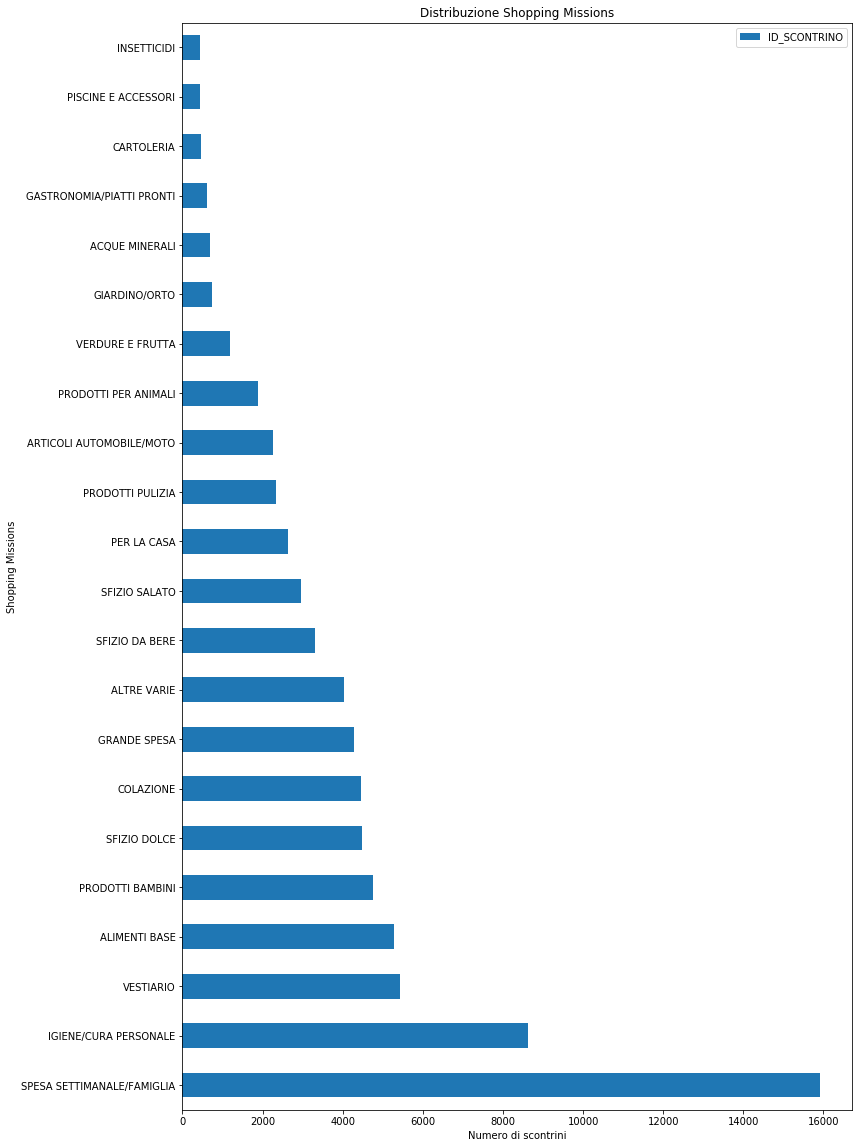

In [104]:
shopping_missions_cnt.plot(kind='barh', figsize=(12, 20))

plt.xlabel('Numero di scontrini')
plt.ylabel('Shopping Missions')
plt.title('Distribuzione Shopping Missions')

plt.show()

### Parte 5: Conclusione

<p style='text-align: justify;'> Con l'obbiettivo di assegnare una shopping mission ad ogni spesa, dal dataset di partenza sono stati creati tre macro-cluster sulla base di numero di articoli messi nel carrello e varietà degli stessi. Due di questi tre cluster, nello specifico Spesa Settimana/Famiglia e Grande Spesa, rappresentano già in se stessi una shopping mission dal mio punto di vista, in quanto ad esempio andare al supermercato con l'idea prescisa di fare un determinato tipo di spesa per rifornirsi di tutto quello che periodicamente io e/o la mia famiglia consumiamo è una shopping mission ben determinata. 
 
 La maggior parte degli scontrini risulta però appartenere al cluster della Piccola Spesa di Necessità che invece per definizione può essere guidata da una vasta gamma di bisogni del momento. Quest'ultimo cluster è stato quindi ulteriormente segmentato individuando per ogni scontrino del cluster la shopping mission principale sulla base dell'ammontare speso in nelle diverse categorie prodotto (variabile che era stata invece esclusa dal processo di definizione dei macro-cluster).

Il risultato finale consiste dunque nell'individuazione di 22 shopping missions. Tra cui emergono principalmente le mission di Spesa Settimana/Famiglia, Igiene/Cura Personale, Alimenti Base, Prodotti Bambini, Sfizio Dolce, Sfizio Salato, Sfizio da Bere e Colazione.

Farsi un'idea degli ordini di grandezza relativi delle diverse shopping mission può aiutare ad ottimizzare l'organizzazione degli scaffali, le offerte personalizzate o semplicemte evidenziare punti forti e punti deboli del supermercato in questione.
</p>